In [1]:
%matplotlib widget

# DEFAULTS

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from tqdm import tqdm
from scipy.integrate import simpson
sys.path.append("..")
from truncation import get_truncation


FORCES = ["LO", "NLO", "N2LO", "N3LO", "N4LO", "N4LO+"]
CUTOFF = [400, 450, 500, 550]

# plt.style.use(['science', 'retro'])

mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'DejaVu Sans'
mpl.rcParams['mathtext.it'] = 'DejaVu Sans:italic'
mpl.rcParams['mathtext.bf'] = 'DejaVu Sans:bold'

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "DejaVu Sans"

plt.rc('text', usetex=True)
# plt.rc('text', usetex=False)
plt.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['lines.linewidth'] = 2

line_styles = {"LO": {"marker": "d", "markevery": 10, "markersize": 3, "color": "tab:cyan"},
               "NLO": {"marker": ".", "markevery": 10, "color": "orange"},
               "N2LO": {"ls":  (0, (5, 3)), "color": "green"},
               "N3LO": {"ls": "dotted", "color": "blue"},
               "N4LO": {"ls": (0, (5, 2, 0.8, 2, 0.8, 2)), "color": "red"},
               "N4LO+": {"color": "black"},
               "AV18": {"ls": (0, (5, 2, 1.3, 2,)), "color": "blueviolet"},
               "SIEGERT": {"color": "blue"},
               "1NC": {"color": "deeppink", "ls": "dashed"},
               "PW": {"ls":  (0, (5, 2, 1.3, 2,)), "color": "green"}
               }
ls_cutoff = {400: line_styles["N4LO"],
             450: line_styles["N4LO+"],
             500: line_styles["N2LO"],
             550: line_styles["N3LO"],
             }

exp_style = [
    {"fmt": "ok"},
    {"fmt": "ok", "markerfacecolor": "None", "markeredgecolor": "k"},
    {"fmt": "sk"},
    {"fmt": "^k"},
    {"fmt": "Xk"},
    {"fmt": "dk"},
]

trunc_colors = {
    "NLO": "bisque",
    "N2LO": "limegreen",
    "N3LO": "dodgerblue",
    "N4LO": "red",
    "N4LO+": "black",
}

marker_common = {"markersize": 6, "elinewidth": 0.9, "capsize": 2.5}


df_my = pd.read_csv("deuteron_all_data.csv")
df_my.T21D2 *= 2
df_my.T22D2 *= 2
df_my.T21D *= 2
df_my.T22D *= 2
df_my.AX *= -1
df_my.AX2 *= -1
df_exp = pd.read_csv("deuteron_exp_diffcross.csv")
df_exp_tot = pd.read_csv("deuteron_exp_totcross.csv")

OBSERVABLES = [ob for ob in df_my.columns.values if ob not in [
    "THCM", "angle", "CUTOFF", "FORCE"]]

my_energies = df_my.Energy.unique()
my_energies.sort()

rachek_bins = pd.read_csv("ExpData/TensoeAnalyzingPower/rachek_t2i_vs_theta.txt", delim_whitespace=True,
                          names=["Emin", "Emax", "Emean", "THmin", "THmax", "THmean",
                                 "T20", "T20stater", "T20syser", "T21", "T21stater", "T21syser",
                                 "T22", "T22stater", "T22syser"])


In [29]:
def relative_diff(*args):
    return (max(args) - min(args))/abs(np.mean(args))

In [30]:
print(*OBSERVABLES)

CROSS CROSS2 P1 P2 PHIP WAVE T11D T20D T21D T22D T11D2 T20D2 T21D2 T22D2 AX AY AZ AX2 AY2 AZ2 POLNOUT(y) POLNOUT2(y) CROSSCAP CROSSCAP2 AYN1CAP AYN1CAP2 Energy


# Tensor analyzing power

## Rachek

### Energy distribution

In [96]:
df_raczek_T20_88 = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/raczek_mishev_T20_88.csv",
                               header=None, skiprows=2,
                               names=["raczek_X", "raczek_Y",
                                      "raczek_errX", "raczek_errY",
                                      "mishev_X", "mishev_Y",
                                      "mishev_errX", "mishev_errY"])
df_raczek_T20_88["raczek_err"] = df_raczek_T20_88["raczek_errY"] - \
    df_raczek_T20_88["raczek_Y"]
df_raczek_T20_88["mishev_err"] = df_raczek_T20_88["mishev_errY"] - \
    df_raczek_T20_88["mishev_Y"]

df_arenh_T20_88 = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/arenhovel_T20.csv",
                              header=None, names=["energy", "T20"])

df_raczek_T22_88 = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/raczek_mishev_T22_88.csv",
                               header=None, skiprows=2,
                               names=["raczek_X", "raczek_Y",
                                      "raczek_errX", "raczek_errY",
                                      "mishev_X", "mishev_Y",
                                      "mishev_errX", "mishev_errY"])
df_raczek_T22_88["raczek_err"] = df_raczek_T22_88["raczek_errY"] - \
    df_raczek_T22_88["raczek_Y"]
df_raczek_T22_88["mishev_err"] = df_raczek_T22_88["mishev_errY"] - \
    df_raczek_T22_88["mishev_Y"]

df_arenh_T22_88 = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/arenhovel_T22.csv",
                              header=None, names=["energy", "T22"])


In [116]:
df_tmp = df_my[(df_my.FORCE == "N4LO+") &
               # (df_my.CUTOFF == 450) &
               (df_my.angle == 88) &
               (df_my.WAVE == "SIEGERT")]
df_tmp = df_tmp.sort_values("Energy")


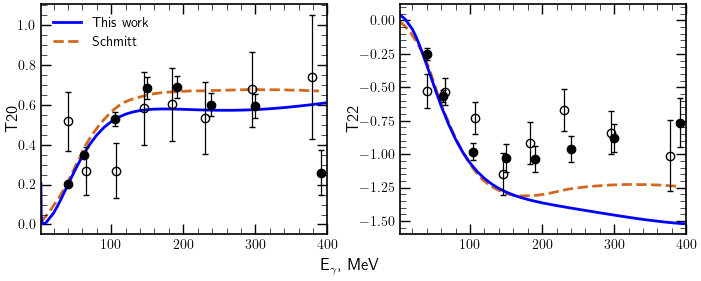

In [119]:
fig, ax = plt.subplots(1, 2, figsize=(7, 2.8), constrained_layout=True)
fig.supxlabel("E$_\gamma$, MeV", size=12)

# ax[0].plot(df_tmp[df_tmp.CUTOFF == 400].Energy,
#            df_tmp[df_tmp.CUTOFF == 400].T20D2,
#            label="N4LO+ 400", zorder=2, lw=2)

ax[0].plot(df_tmp[df_tmp.CUTOFF == 450].Energy,
           df_tmp[df_tmp.CUTOFF == 450].T20D2,
           label="This work", zorder=2, lw=2, **line_styles["SIEGERT"])

# ax[0].plot(df_tmp[df_tmp.CUTOFF == 500].Energy,
#            df_tmp[df_tmp.CUTOFF == 500].T20D2,
#            label="N4LO+ 500", zorder=2, lw=2)

# ax[0].plot(df_tmp[df_tmp.CUTOFF == 550].Energy,
#            df_tmp[df_tmp.CUTOFF == 550].T20D2,
#            label="N4LO+ 550", zorder=2, lw=2)
ax[0].plot(df_arenh_T20_88.energy, df_arenh_T20_88.T20, label="Arenhovel",
           ls="dashed", zorder=1, lw=2, color="chocolate")
ax[0].errorbar(df_raczek_T20_88.raczek_X, df_raczek_T20_88.raczek_Y, yerr=df_raczek_T20_88.raczek_err,
               zorder=3, label="Rachek et al", **exp_style[0], **marker_common)
ax[0].errorbar(df_raczek_T20_88.mishev_X, df_raczek_T20_88.mishev_Y, yerr=df_raczek_T20_88.mishev_err,
               zorder=3, label="Mishev et al", **exp_style[1], **marker_common)
# ax[0].legend(fontsize=6)
ax[0].tick_params(which='minor', direction='in', length=4,
                  width=0.5, top=True, right=True)
ax[0].tick_params(which='major', direction='in',
                  length=7, width=1, top=True, right=True)
ax[0].set_ylabel("T20", labelpad=-1, size=12)

ax[1].plot(df_tmp[df_tmp.CUTOFF == 450].Energy,
           df_tmp[df_tmp.CUTOFF == 450].T22D2,
           label="N4LO+",
           zorder=2, lw=2, **line_styles["SIEGERT"])
ax[1].plot(df_arenh_T22_88.energy, df_arenh_T22_88.T22,
           label="arenhovel", ls="dashed", zorder=1,
           lw=2, color="chocolate")
ax[1].errorbar(df_raczek_T22_88.raczek_X, df_raczek_T22_88.raczek_Y, yerr=df_raczek_T22_88.raczek_err,
               zorder=3, label="Rachek et al", **exp_style[0], **marker_common)
ax[1].errorbar(df_raczek_T22_88.mishev_X, df_raczek_T22_88.mishev_Y, yerr=df_raczek_T22_88.mishev_err,
               zorder=3, label="Mishev et al", **exp_style[1], **marker_common)
# ax[1].legend(fontsize=6)
ax[1].tick_params(which='minor', direction='in', length=4,
                  width=0.5, top=True, right=True)
ax[1].tick_params(which='major', direction='in',
                  length=7, width=1, top=True, right=True)
ax[1].set_ylabel("T22", labelpad=-1, size=12)
ax[0].set_xlim([2.5, 400])
ax[1].set_xlim([2.5, 400])
# plt.ylabel(
ax[0].legend(["This work", "Schmitt"])
# fig.tight_layout()
plt.savefig(f"Figures_De/T20_T22_vs_en.pdf", dpi=600, facecolor="white")
plt.show()


### Angular distribution

In [91]:
rachek_angular = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/rachek_t2i_vs_theta.txt", delim_whitespace=True,
                             names=["Emin", "Emax", "Emean", "THmin", "THmax", "THmean",
                                    "T20", "T20stater", "T20syser", "T21", "T21stater", "T21syser",
                                    "T22", "T22stater", "T22syser"])
rachek_angular["THerr"] = rachek_angular.THmean - rachek_angular.THmin


In [92]:
espans = list(map(lambda x: list(map(lambda x: int(float(x)), x.split())),
                  (rachek_angular.Emin.astype(str) + " " + rachek_angular.Emax.astype(str)).unique()))


In [9]:
print(espans)


[[25, 45], [45, 70], [70, 100], [100, 140], [140, 180], [180, 230], [230, 330], [330, 440]]


In [93]:
plt.close("all")


In [105]:
for espan in tqdm(espans):
    df_sieg = df_my[(df_my.FORCE == "N4LO+") &
                    (df_my.CUTOFF == 450) &
                    (df_my.Energy >= espan[0]) &
                    (df_my.Energy <= espan[1]) &
                    (df_my.angle >= 20) &
                    (df_my.angle <= 110) &
                    (df_my.WAVE == "SIEGERT")]
    df_1nc = df_my[(df_my.FORCE == "N4LO+") &
                   (df_my.CUTOFF == 450) &
                   (df_my.Energy >= espan[0]) &
                   (df_my.Energy <= espan[1]) &
                   (df_my.angle >= 20) &
                   (df_my.angle <= 110) &
                   (df_my.WAVE == "1NC")]
    df_exp = rachek_angular[(rachek_angular.Emin == espan[0]) & (
        rachek_angular.Emax == espan[1])]
    fig, ax = plt.subplots(1, 3, figsize=(9.5, 2.8), constrained_layout=True)
    fig.suptitle("E$_\gamma$ = {} - {} MeV".format(*espan))
    fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", size=12)

    for i, obs in enumerate(["T20", "T21", "T22"]):

        # Siegert
        df_gr = df_sieg.groupby(
            "angle")[obs+"D2"].agg(['min', 'max', 'mean']).reset_index()
        ax[i].fill_between(x="angle", y1="min", y2="max", data=df_gr,
                           zorder=3, alpha=0.4, **line_styles["SIEGERT"])
        ax[i].plot(df_gr.angle, df_gr["mean"],
                   zorder=3, label="Siegert", **line_styles["SIEGERT"])
        # SN current
        df_gr_1nc = df_1nc.groupby(
            "angle")[obs+"D2"].agg(['min', 'max', 'mean']).reset_index()
        ax[i].fill_between(x="angle", y1="min", y2="max", data=df_gr_1nc,
                           zorder=2, alpha=0.3,
                           **line_styles["1NC"])
        ax[i].plot(df_gr_1nc.angle, df_gr_1nc["mean"],
                   zorder=2, label="SN", **line_styles["1NC"])
        # experiment
        ax[i].errorbar(x="THmean", y=obs, yerr=obs + "stater", data=df_exp,
                       zorder=4, label=None, **exp_style[0], **marker_common)

        # style
        ax[i].axhline(c="k", zorder=1, lw=1.2)
        ax[i].set_ylabel(obs, labelpad=-1, size=12)
        ax[i].set_xlim([20, 110])
        ax[i].tick_params(which='minor', direction='in',
                          length=4, width=0.5, top=True, right=True)
        ax[i].tick_params(which='major', direction='in',
                          length=7, width=1, top=True, right=True)
    ax[1].legend(fontsize=8)
    plt.savefig("Figures_De/Tensor_analyzing_power_angular_E{}-{}.pdf".format(*
                                                                                  espan), dpi=600, facecolor="white")
    # plt.show()
    plt.close()
    # break


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


### Integrated

In [108]:
from copy import deepcopy

rachek_integr = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/rachek_t2i_vs_egamma.txt",
                            delim_whitespace=True,
                            names=['E-gamma_start', 'E-gamma_end', 'E-gamma_mean', 'Theta-p_start',
                                   'Theta-p_end', 'Theta-p_mean', 'T20_value', 'T20_stat_err',
                                   'T20_sys_err', 'T21_value', 'T21_stat_err', 'T21_sys_err',
                                   'T22_value', 'T22_stat_err', 'T22_sys_err'])
rachek_integr = rachek_integr[rachek_integr["E-gamma_start"] < 400]
Eerr = np.array(list(zip(rachek_integr["E-gamma_mean"]-rachek_integr["E-gamma_start"],
                         rachek_integr["E-gamma_end"]-rachek_integr["E-gamma_mean"])))


In [111]:
# angles = (24, 48)
angles = (70, 102)
data = {
    "SIEGERT": {
        "min": [],
        "max": [],
        "mean": []
    },
    "1NC": {
        "min": [],
        "max": [],
        "mean": []
    }
}
data_all = {}
for i in range(3):
    obs = f"T2{i}"
    data_all[obs] = deepcopy(data)

    df_local = df_my[(df_my.FORCE == "N4LO+") &
                     (df_my.CUTOFF == 450) &
                     (df_my.angle >= angles[0]) &
                     (df_my.angle <= angles[1])]
    for energy in tqdm(my_energies, desc=obs):
        for wave in ["1NC", "SIEGERT"]:
            df_tmp = df_local[
                (df_local.Energy == energy) &
                (df_local.WAVE == wave)
            ]
            x = df_tmp.THCM.values
            y = df_tmp[obs + "D2"].values
            mean = np.mean(y)
            # std = np.std(y)
            data_all[obs][wave]["mean"].append(mean)
            data_all[obs][wave]["min"].append(np.min(y))
            data_all[obs][wave]["max"].append(np.max(y))


T22: 100%|██████████| 50/50 [00:00<00:00, 614.27it/s]


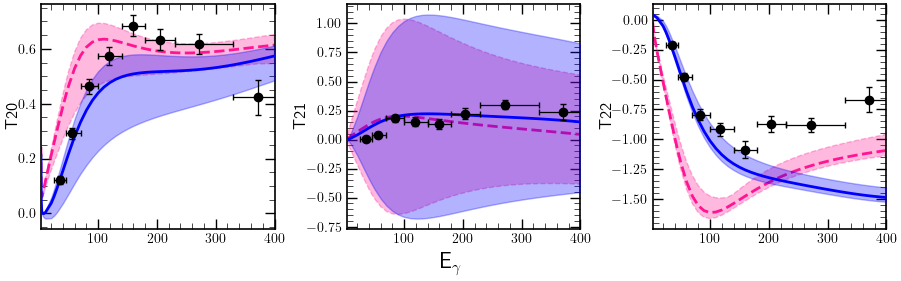

In [112]:
fig, ax = plt.subplots(1, 3, figsize=(9, 2.8), constrained_layout=True)
fig.supxlabel("E$_\gamma$", size=16)
for i in range(3):
    obs = f"T2{i}"
    for num, current_type in enumerate(["1NC", "SIEGERT"]):
        ax[i].fill_between(my_energies, data_all[obs][current_type]["min"],
                           data_all[obs][current_type]["max"],
                           alpha=0.3, zorder=2+num,
                           **line_styles[current_type])
        ax[i].plot(my_energies, data_all[obs][current_type]["mean"],
                   zorder=2+num, **line_styles[current_type])

    ax[i].errorbar(x="E-gamma_mean", y=f"{obs}_value", yerr=f"{obs}_stat_err",
                   xerr=Eerr[np.where((rachek_integr["Theta-p_start"] >= angles[0]) &
                                      (rachek_integr["Theta-p_end"] <= angles[1]))].T,
                   data=rachek_integr[(rachek_integr["Theta-p_start"] >= angles[0]) &
                                      (rachek_integr["Theta-p_end"] <= angles[1])],
                   zorder=4, **exp_style[0], **marker_common)
    ax[i].tick_params(which='minor', direction='in',
                      length=4, width=0.5, top=True, right=True)
    ax[i].tick_params(which='major', direction='in',
                      length=7, width=1, top=True, right=True)
#     ax[i].grid(zorder=1)
#     ax[i].axhline(c="k", zorder=1, lw=1.2)
    ax[i].set_ylabel(obs, size=12, labelpad=-1)
    ax[i].set_xlim([2.5, 400])
# fig.tight_layout()
plt.savefig("Figures_De/TensorPower_Th{}-{}.pdf".format(*
                                                            angles), dpi=600, facecolor="white")
plt.show()


## PW 1NC

In [136]:
df_tmp = df_my[(df_my.CUTOFF == 450) &
            (df_my.Energy == 30) &
            (df_my.FORCE == "N4LO+") &
            (df_my.WAVE.isin(["1NC", "SIEGERT"]))]
df_tmp.sort_values("angle", inplace=True)

/tmp/ipykernel_1194987/3502276747.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.sort_values("angle", inplace=True)


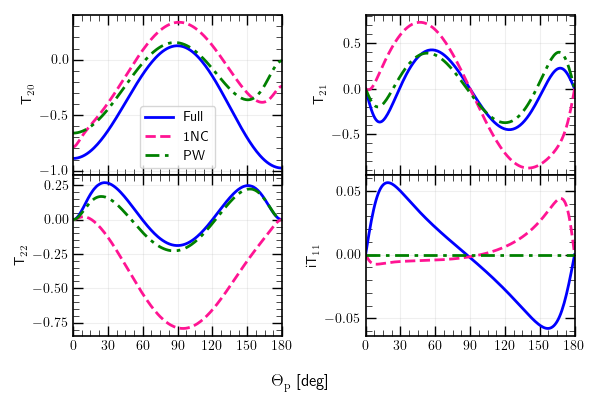

In [137]:
fig = plt.figure(figsize=(6, 4))
obs = "T11D2"
gs = fig.add_gridspec(nrows=2, ncols=2, hspace=0)
axes = gs.subplots(sharex=True)
fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.02, size=12)
# ylabel = obs
# fig.supylabel(ylabel, x=0.03, size=16)
for obs, lab, ax in zip(["T20D", "T21D", "T22D", "T11D"],
                    ["T$_{20}$", "T$_{21}$", "T$_{22}$", "iT$_{11}$"],
                    axes.flatten()):
    ax.plot(df_tmp[(df_tmp.WAVE == "SIEGERT")].angle,
                df_tmp[(df_tmp.WAVE == "SIEGERT")][obs+"2"],
                **line_styles["SIEGERT"], label="Full")
    ax.plot(df_tmp[(df_tmp.WAVE == "1NC")].angle,
            df_tmp[(df_tmp.WAVE == "1NC")][obs+"2"],
                **line_styles["1NC"], label="1NC")
    # axes[i].plot(df_tmp[(df_tmp.WAVE == "1NC")].angle, df_tmp[(df_tmp.WAVE == "1NC")].CROSS)
    ax.plot(df_tmp[(df_tmp.WAVE == "SIEGERT")].angle,
                   df_tmp[(df_tmp.WAVE == "SIEGERT")][obs],
                **line_styles["PW"], label="PW")
    
    ax.set_ylabel(lab)

axes[0,0].legend()
for j, ax in enumerate(axes.flatten()):
    # style
    # tmp
    # if j == 1:
    #     ax.legend(fontsize=9, handlelength=3, loc="upper center")
    # else:
    #     ax.legend(fontsize=9, handlelength=3, loc="best")
    # ax.legend(fontsize=9, handlelength=3, loc="best")
    
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.tick_params(which='minor', direction='in', length=4,
                width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                length=7, width=1, top=True, right=True, zorder=1)
    ax.set_xticks(np.arange(0, 180+j-1, 30))
    ax.set_xlim([0, 180])
    ax.grid(alpha=0.2)
    ax.set_zorder(-1)
fig.tight_layout()
plt.savefig(f"../Figures_De/TensorPowers_pw_1nc.pdf",
                    dpi=600, facecolor="white")

In [143]:
obs="T20"
(df_tmp[(df_tmp.Energy == 30) & (df_tmp.WAVE == "SIEGERT")][[
    obs + "D", obs + "D2"]].apply(lambda x: relative_diff(*x), axis=1)*100).iloc[90]

19.777058612010066

In [145]:
obs="T21"
(df_tmp[(df_tmp.Energy == 30) & (df_tmp.WAVE == "SIEGERT")][[
    obs + "D", obs + "D2"]].apply(lambda x: relative_diff(*x), axis=1)*100).iloc[60]

/tmp/ipykernel_1194987/1021701444.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (max(args) - min(args))/abs(np.mean(args))


12.930817610062892

In [146]:
obs="T22"
(df_tmp[(df_tmp.Energy == 30) & (df_tmp.WAVE == "SIEGERT")][[
    obs + "D", obs + "D2"]].apply(lambda x: relative_diff(*x), axis=1)*100).iloc[90]

/tmp/ipykernel_1194987/1021701444.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (max(args) - min(args))/abs(np.mean(args))


17.780573972801623

In [149]:
obs="T11"
(df_tmp[(df_tmp.Energy == 30) & (df_tmp.WAVE == "SIEGERT")][[
    obs + "D", obs + "D2"]].apply(lambda x: relative_diff(*x), axis=1)*100).iloc[20]

/tmp/ipykernel_1194987/1021701444.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (max(args) - min(args))/abs(np.mean(args))


200.0

In [154]:
(df_tmp[df_tmp.Energy == 30].pivot(index="angle", columns="WAVE")["T11D2"].apply(lambda x: relative_diff(*x), axis=1)*100).iloc[20]

/tmp/ipykernel_1194987/1021701444.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (max(args) - min(args))/abs(np.mean(args))


249.54567192730752

## Cross-like

In [97]:
def make_fig(obs, energy, cutoff, df, exp=None, wave="SIEGERT", ylabel=None, save=True):
    df_tmp = df[(df.CUTOFF == cutoff) &
               (df.Energy == energy) &
               (df.WAVE == wave)]
    df_tmp.sort_values("angle", inplace=True)
    df_piv = df_tmp.pivot(index="angle", columns="FORCE")[obs].reindex(FORCES, axis=1)
    df_trunc = get_truncation(df_piv, energy)

    fig = plt.figure(figsize=(5, 8.4))
    gs = fig.add_gridspec(nrows=3, hspace=0)
    axes = gs.subplots(sharex=True)
    fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.02, size=16)
    if not ylabel:
        ylabel = obs
    fig.supylabel(ylabel, x=0.03, size=16)
    for force in FORCES:
        df_tmp = df[(df.FORCE == force) &
                    (df.CUTOFF == cutoff) &
                    (df.Energy == energy) &
                    (df.WAVE == "SIEGERT")]
        axes[0].plot(df_tmp.angle, df_tmp[obs],
                    **line_styles[force], label=force)
        if force != "LO":
            axes[1].fill_between(df_tmp.angle, df_tmp[obs].values+df_trunc[force].values,
                                df_tmp[obs].values-df_trunc[force].values, label=force,
                                color=trunc_colors[force])
        # break
    for cut in CUTOFF:
        df_tmp = df[(df.FORCE == "N4LO+") &
                    (df.CUTOFF == cut) &
                    (df.Energy == energy) &
                    (df.WAVE == "SIEGERT")]
        axes[2].plot(df_tmp.angle, df_tmp[obs],
                    **ls_cutoff[cut], label=cut)
    df_av18 = df[(df.FORCE == "AV18") & (df.Energy == energy)]
    for j, ax in enumerate(axes):
        if j != 1:
            ax.plot(df_av18.angle, df_av18[obs],
                    **line_styles["AV18"], label="AV18")
        # style
        # tmp
        # if j == 1:
        #     ax.legend(fontsize=9, handlelength=3, loc="upper center")
        # else:
        #     ax.legend(fontsize=9, handlelength=3, loc="best")
        ax.legend(fontsize=9, handlelength=3, loc="best")
        
        ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
        ax.tick_params(which='minor', direction='in', length=4,
                    width=0.5, top=True, right=True)
        ax.tick_params(which='major', direction='in',
                    length=7, width=1, top=True, right=True, zorder=1)
        ax.set_xticks(np.arange(0, 180+j-1, 30))
        ax.set_xlim([0, 180])
        ax.grid(alpha=0.2)
        ax.set_zorder(-1)
    fig.tight_layout()
    if save:
        plt.savefig(f"../Figures_De/{obs}_{energy}mev.pdf",
                    dpi=600, facecolor="white")
    return ax, fig

In [93]:
print(OBSERVABLES)

['CROSS', 'CROSS2', 'P1', 'P2', 'PHIP', 'WAVE', 'T11D', 'T20D', 'T21D', 'T22D', 'T11D2', 'T20D2', 'T21D2', 'T22D2', 'AX', 'AY', 'AZ', 'AX2', 'AY2', 'AZ2', 'POLNOUT(y)', 'POLNOUT2(y)', 'CROSSCAP', 'CROSSCAP2', 'AYN1CAP', 'AYN1CAP2', 'Energy']


/tmp/ipykernel_1194987/601713361.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.sort_values("angle", inplace=True)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is depreca

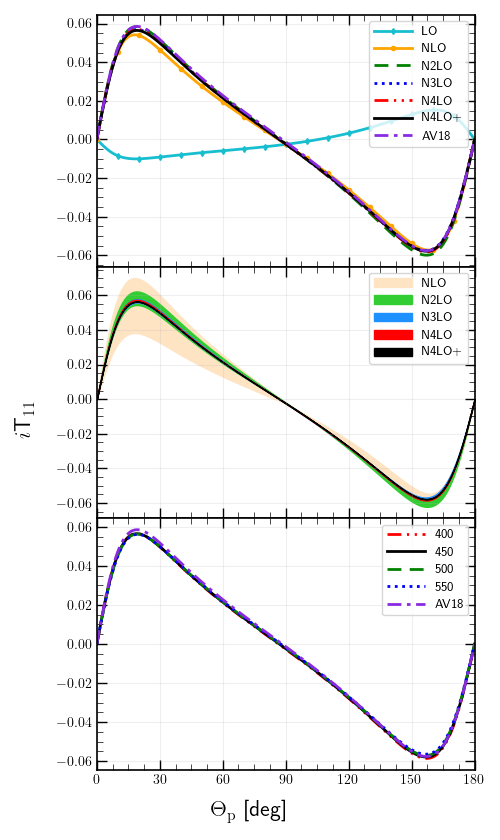

In [98]:
# for en in [100, 120]:
#     ax, fig = make_fig("AX2", en, 450, df_my, save=True, ylabel="$\Sigma_\gamma$")
ax, fig = make_fig("T11D2", 30, 450, df_my, save=True,
                   ylabel="$i$T$_{11}$")


## Relative difference (spread)

### Cutoff

In [134]:
df_tmp = df_my[(df_my.FORCE == "N4LO+") &
                    (df_my.Energy == 30) &
                    (df_my.WAVE == "SIEGERT")]
reldif2 = df_tmp.pivot(index="angle", columns="CUTOFF")["T11D2"].apply(lambda x: relative_diff(*x), axis=1)*100

/tmp/ipykernel_1194987/1021701444.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (max(args) - min(args))/abs(np.mean(args))


In [135]:
reldif2.iloc[20]

0.6750155431210558

In [20]:
absdif = df_tmp.pivot(index="angle", columns="CUTOFF")["T21D2"].apply(np.ptp, axis=1)

In [21]:
absdif[90]

0.004674

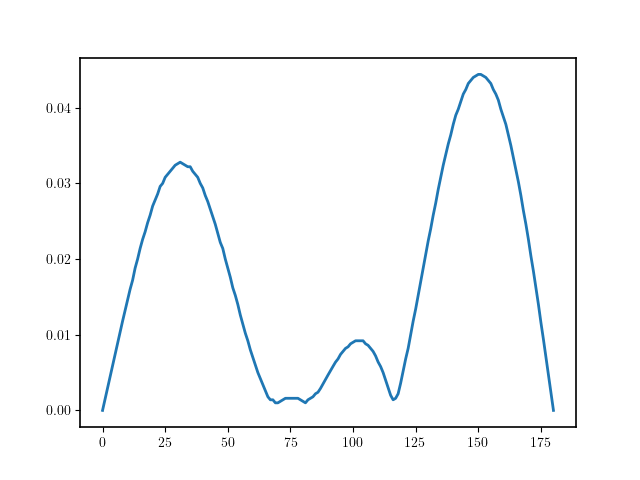

In [24]:
plt.figure()
plt.plot(absdif)

### Truncation

In [99]:
df_tmp = df_my[(df_my.CUTOFF == 450) &
                    (df_my.Energy == 30) &
                    (df_my.WAVE == "SIEGERT")]
df_tmp.sort_values("angle", inplace=True)

/tmp/ipykernel_1194987/1872114333.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.sort_values("angle", inplace=True)


In [121]:
obs="T11D2"
energy=30
df_piv = df_tmp.pivot(index="angle", columns="FORCE")[obs].reindex(FORCES, axis=1)
df_trunc = get_truncation(df_piv, energy)

/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in 

In [122]:
df_tmp[df_tmp.FORCE=="N4LO+"][obs].shape

(181,)

In [123]:
df_loc = df_tmp[df_tmp.FORCE=="N4LO+"]

In [124]:
df_loc["plus"] = df_loc[obs] + df_trunc["N4LO+"].values
df_loc["minus"] = df_loc[obs] - df_trunc["N4LO+"].values

/tmp/ipykernel_1194987/54163983.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc["plus"] = df_loc[obs] + df_trunc["N4LO+"].values
/tmp/ipykernel_1194987/54163983.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc["minus"] = df_loc[obs] - df_trunc["N4LO+"].values


In [125]:
(df_loc[["plus", "minus"]].apply(lambda x: relative_diff(*x), axis=1)*100).iloc[20]

/tmp/ipykernel_1194987/1021701444.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (max(args) - min(args))/abs(np.mean(args))


0.209885234359299